In [1]:
import pandas as pd
import subprocess
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
#read parquet files
mistral_nodes = pd.read_parquet('../data/mistral_10k/artifacts/create_final_nodes.parquet')
mistral_relationships = pd.read_parquet('../data/mistral_10k/artifacts/create_final_relationships.parquet')
llava_nodes = pd.read_parquet('../data/llava_10k/artifacts/create_final_nodes.parquet')
llava_relationships = pd.read_parquet('../data/llava_10k/artifacts/create_final_relationships.parquet')


remove node with degree 0. these nodes have no connections and cause the graph to appear cluttered.

In [3]:
mistral_nodes = mistral_nodes[mistral_nodes['id'].isin(mistral_relationships['source']) | mistral_nodes['id'].isin(mistral_relationships['target'])]
llava_nodes = llava_nodes[llava_nodes['id'].isin(llava_relationships['source']) | llava_nodes['id'].isin(mistral_relationships['target'])]

**Metrics Calculated:**
- Modularity Score: Uses the Louvain community detection algorithm to partition nodes into communities and calculates the modularity score. Modularity measures the strength of division of the network into modules (communities). Higher values are preferred as they indicate a more defined community structure.

- Clustering Coefficient: Calculates the average clustering coefficient of the graph, which indicates how nodes tend to cluster together. Higher values are preferred, as they suggest more local clustering within the network.

- Density: Measures the ratio of edges to the possible number of edges, giving an idea of how dense the graph is. Higher values may be preferred if more connectivity is desired, but it depends on the context of the graph.

- Average Degree Centrality: Computes the degree centrality for each node, then averages these values to get an overall measure of centrality. Higher values are preferred, as they indicate more connections per node on average.

- Assortativity: Calculates the degree assortativity, which is a measure of the similarity of connections in the graph (e.g., if nodes with high degrees connect to other high-degree nodes). Positive values may be preferred in social networks, while negative values might suit hierarchical structures.

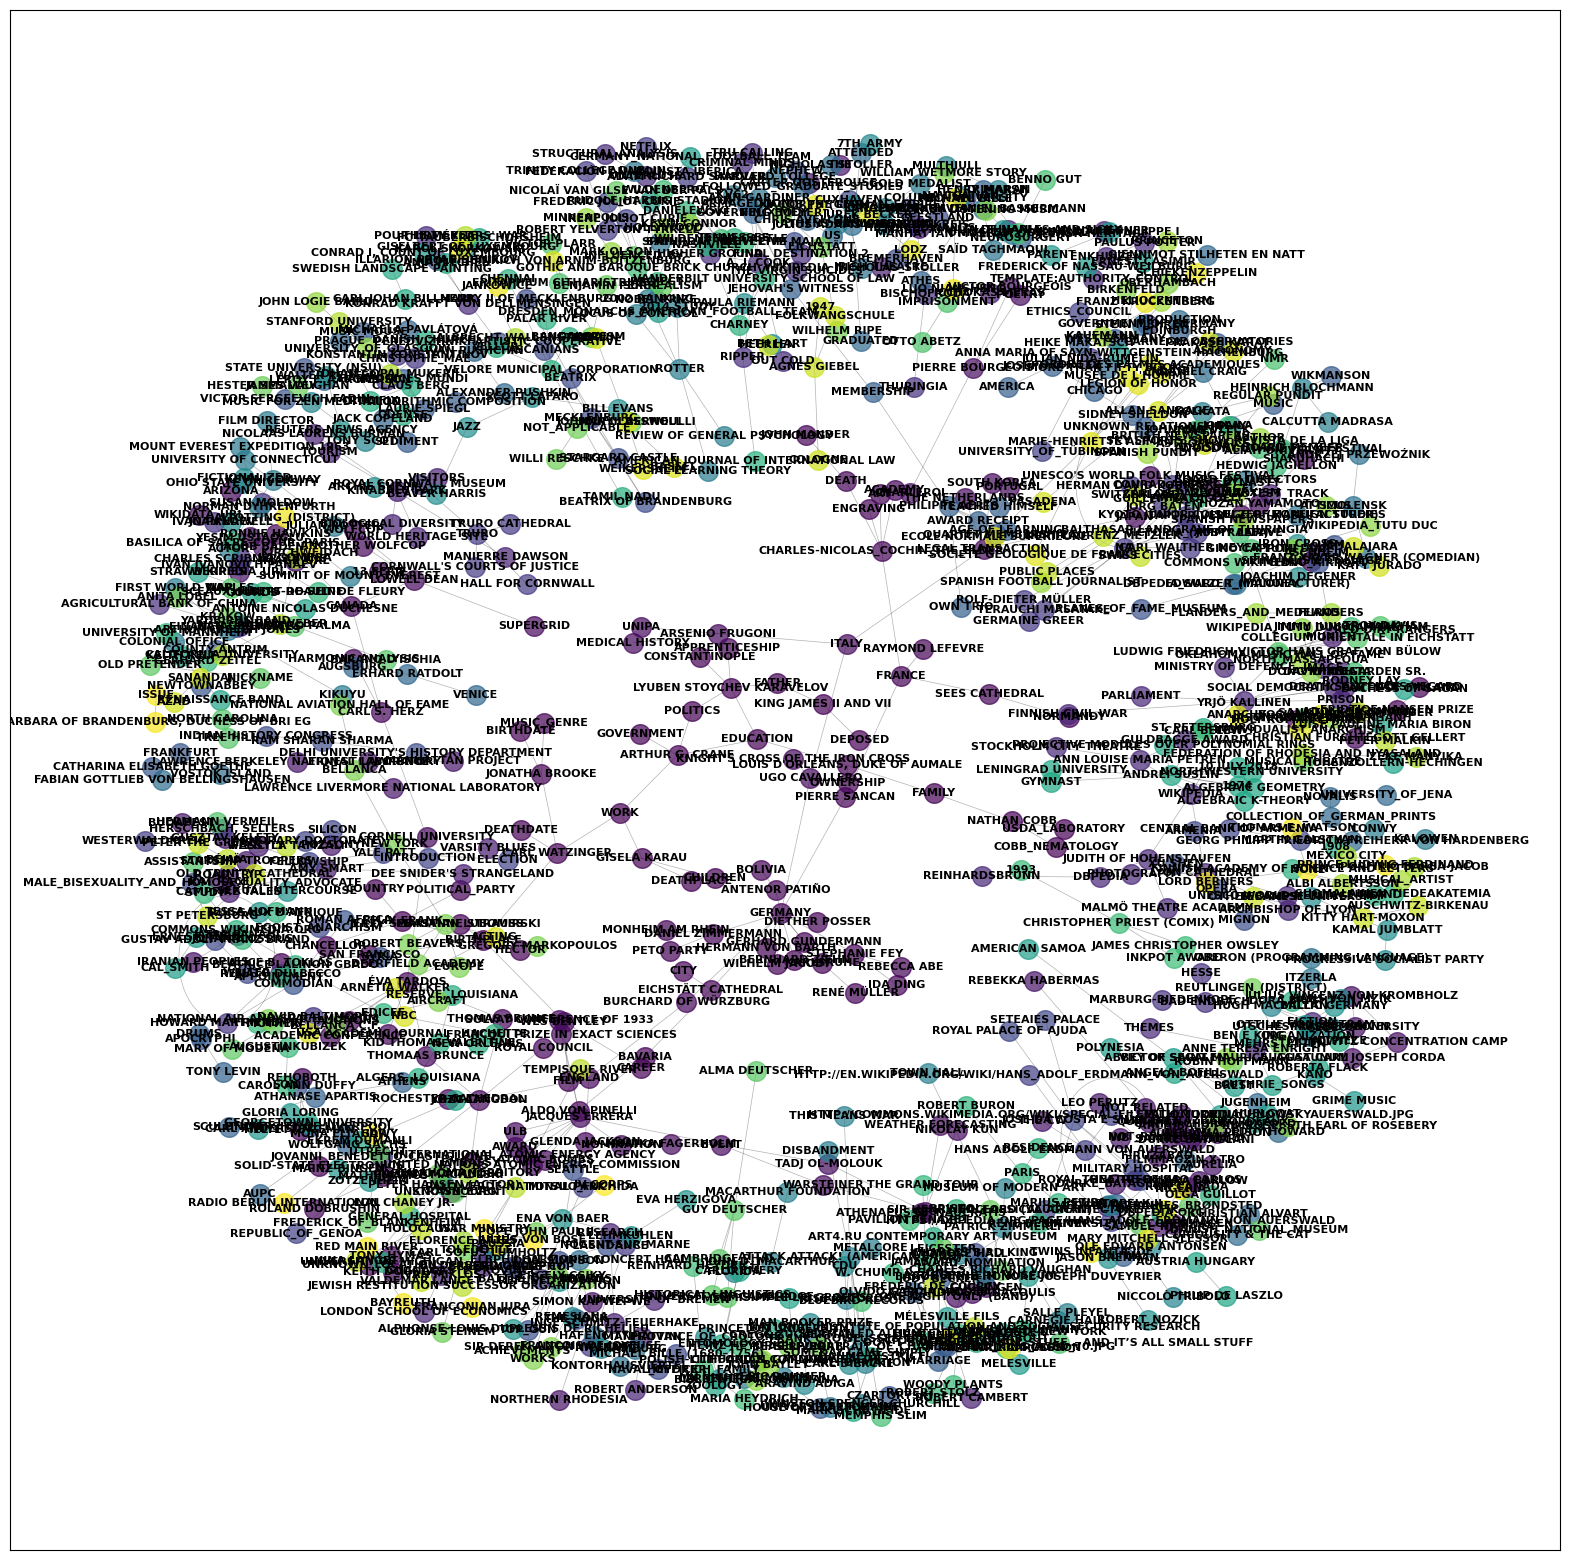

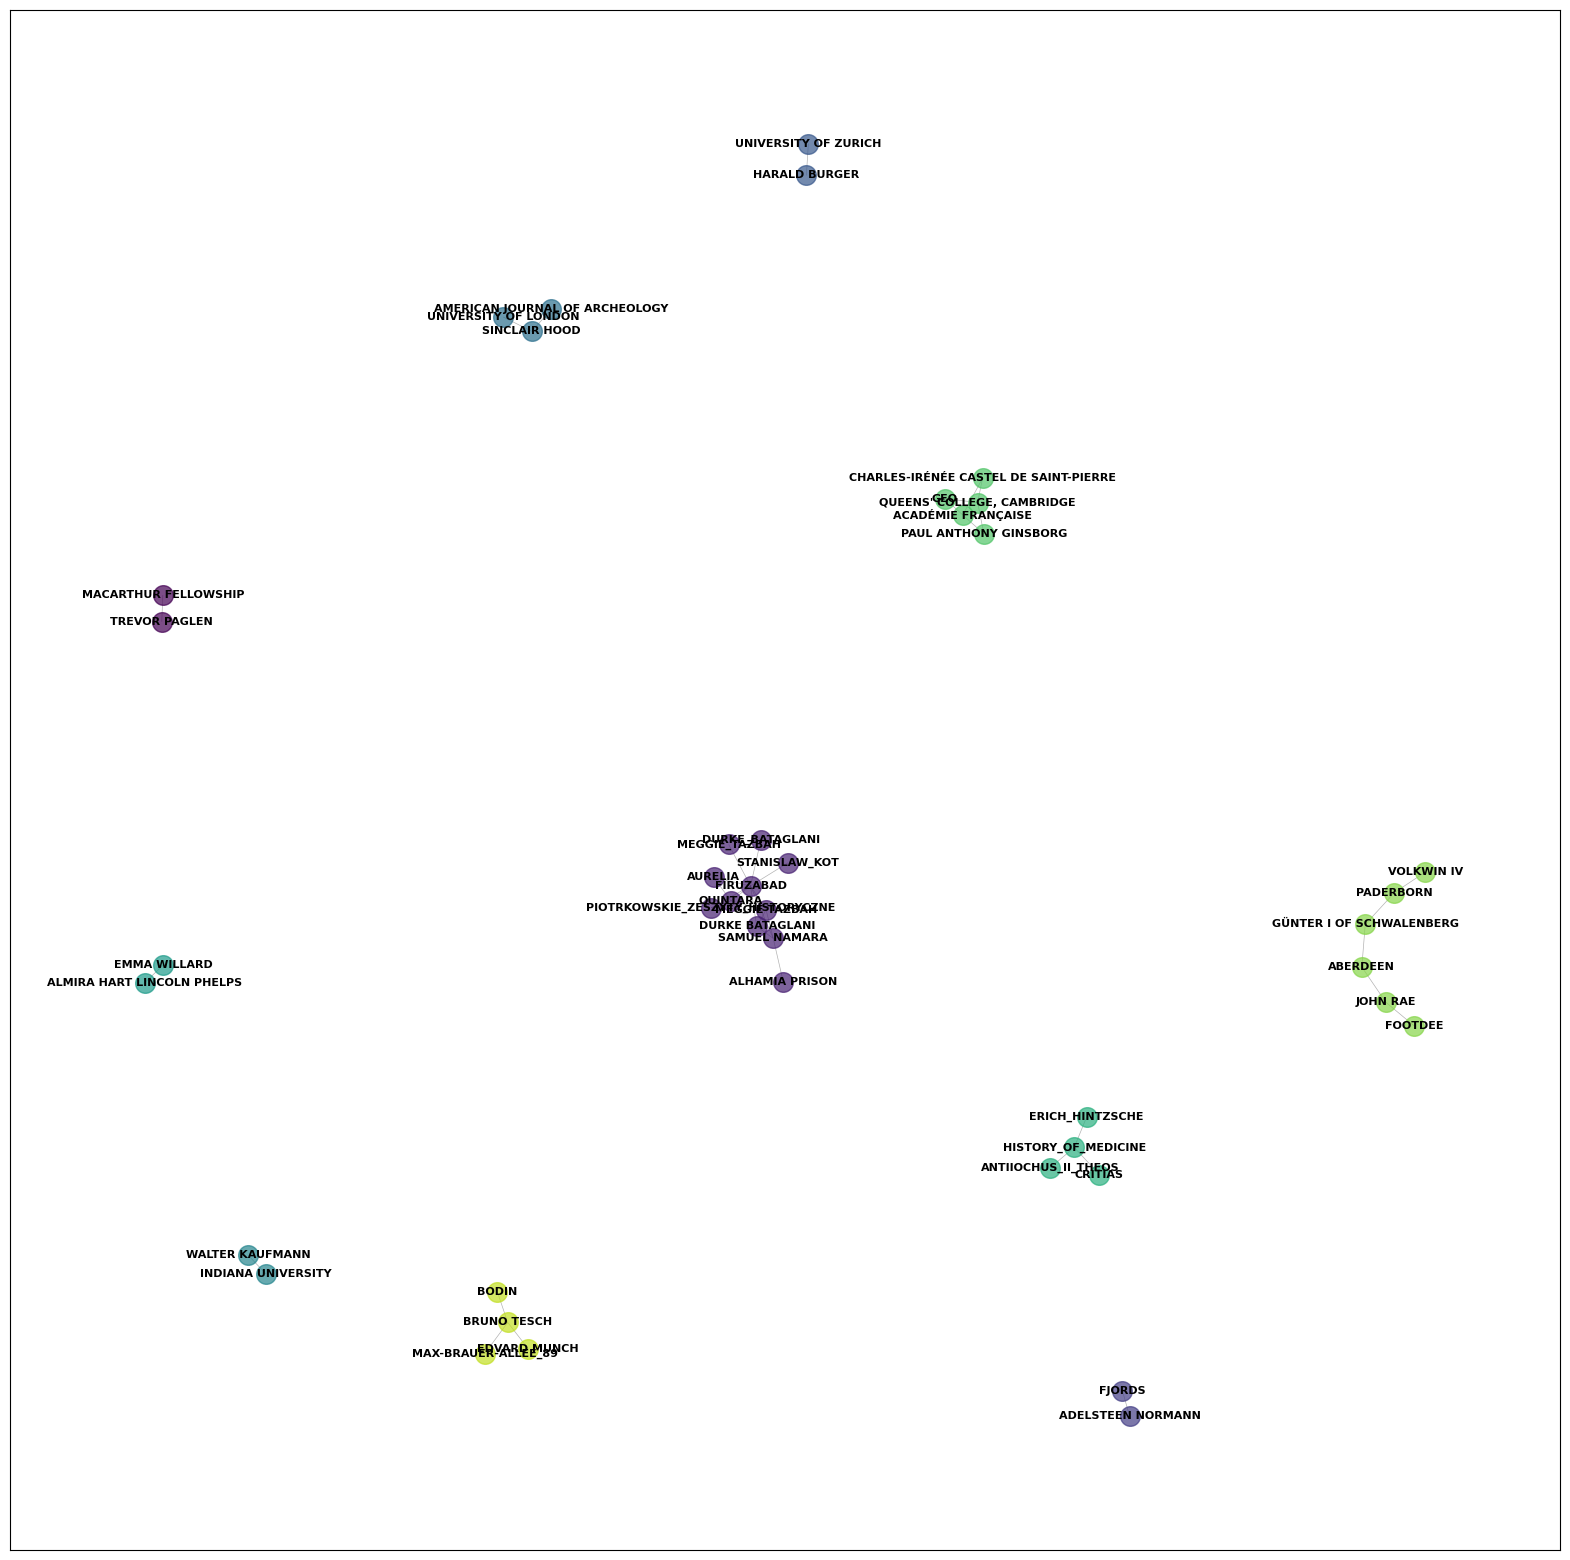

Comparison of Graph Evaluation Metrics between Mistral and Llava:
                      Metric   Mistral     Llava
0           emodularity_scor  0.983125  0.785000
1     clustering_coefficient  0.025617  0.112403
2  average_degree_centrality  0.001606  0.044297
3                    density  0.001606  0.044297
4              assortativity -0.055115 -0.004536


In [4]:
import networkx as nx
import community as community_louvain 
import community.community_louvain as community_louvain
# communities =community_louvain.best_partition(G) # Ensure you have python-louvain installed
import matplotlib.pyplot as plt
import pandas as pd


# Function to cluster and visualize the knowledge graph
def cluster_and_visualize_knowledge_graph(nodes_df, relationships_df):
    # Ensure data types are correct for numeric operations
    nodes_df['id'] = nodes_df['id'].astype(str)  # Ensure 'id' is a string if it represents labels
    nodes_df['size'] = pd.to_numeric(nodes_df['size'], errors='coerce').fillna(1)  # Ensure 'size' is numeric
    relationships_df['source'] = relationships_df['source'].astype(str)
    relationships_df['target'] = relationships_df['target'].astype(str)

    # Initialize the graph
    G = nx.Graph()
    for _, node in nodes_df.iterrows():
        G.add_node(node['id'], label=node['title'], size=node['size'] * 10) 
    for _, rel in relationships_df.iterrows():
        G.add_edge(rel['source'], rel['target'], label=rel['description'])

    # Apply the Louvain method for community detection
    partition = community_louvain.best_partition(G)

    # Draw the graph
    plt.figure(figsize=(20, 20))
    pos = nx.spring_layout(G, k=0.1, iterations=50)

    # Draw nodes with colors by community
    cmap = plt.get_cmap('viridis')
    unique_communities = set(partition.values())
    for community in unique_communities:
        nodes_in_community = [node for node, comm in partition.items() if comm == community]
        nx.draw_networkx_nodes(G, pos, nodelist=nodes_in_community,
                               node_color=[cmap(community / len(unique_communities))], node_size=200, alpha=0.7)

    nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.3)
    nx.draw_networkx_labels(G, pos, font_size=8, font_color="black", font_weight="bold")
    plt.show()

    return G  

G1 = cluster_and_visualize_knowledge_graph(mistral_nodes, mistral_relationships)
G2 = cluster_and_visualize_knowledge_graph(llava_nodes, llava_relationships)
# Evaluate the graph
def evaluate_graph(G):
    partition = community_louvain.best_partition(G)
    modularity_score = community_louvain.modularity(partition, G)
    clustering_coefficient = nx.average_clustering(G)
    density = nx.density(G)
    avg_degree_centrality = sum(dict(nx.degree_centrality(G)).values()) / len(G)
    assortativity = nx.degree_assortativity_coefficient(G)

    return {
    "emodularity_scor": modularity_score,
    "clustering_coefficient": clustering_coefficient,
    "average_degree_centrality": avg_degree_centrality,
    "density": density,
    "assortativity": assortativity
    }

# Evaluate the clustered graph
# Evaluate the clustered graphs for both models
evaluation_results_mistral = evaluate_graph(G1)
evaluation_results_llava = evaluate_graph(G2)

# Create a DataFrame for a side-by-side comparison
comparison_df = pd.DataFrame({
    "Metric": evaluation_results_mistral.keys(),
    "Mistral": evaluation_results_mistral.values(),
    "Llava": evaluation_results_llava.values()
})

print("Comparison of Graph Evaluation Metrics between Mistral and Llava:")
print(comparison_df)


Modularity Score:

- Mistral: 0.983
- Llava: 0.785
- Interpretation: Mistral achieves a higher modularity score, indicating it better identifies clusters or communities within the graph. This suggests that Mistral is more effective at grouping related nodes, which may be useful for applications needing clear community detection.

Clustering Coefficient:

- Mistral: 0.0256
- Llava: 0.1124
- Interpretation: Llava has a significantly higher clustering coefficient, which means it forms more local clusters of interconnected nodes. This could indicate a more interconnected graph structure, potentially beneficial for closely linked networks or denser connections.

Average Degree Centrality and Density:

Both metrics are the same for each model, showing consistency:
- Mistral: 0.0016
- Llava: 0.0443
- Interpretation: Llava’s higher values for both average degree centrality and density indicate a more densely connected network, suggesting that Llava has more connections on average per node and an overall more tightly connected structure.

Assortativity:

- Mistral: -0.055
- Llava: -0.0045
- Interpretation: Both models exhibit a slight disassortative mixing pattern (negative assortativity), though Llava is closer to neutral. This metric indicates that nodes in the graph are more likely to connect with nodes that have differing degrees. This tendency is slightly more pronounced in Mistral, suggesting it might better capture diverse relationships between nodes of varying degrees.

Overall Evaluation: Mistral shows strengths in identifying modular structures with a higher modularity score, indicating clearer community structures, while Llava tends toward a denser, more interconnected network with a higher clustering coefficient and density. Depending on the application requirements, these differences could guide the choice of model:

### Orphaned Nodes Check

This function identifies **orphaned nodes** within the graph. 

- **Orphaned nodes** are entities that are not connected to any other nodes through relationships. 
- This could indicate missing relationships or data extraction issues.
  
The code:
1. Extracts the connected entities from the relationships dataframe.
2. Identifies nodes whose `title` is not part of the connected entities.
3. Prints the list of orphaned nodes for further analysis.

**Impact:** 
A large number of orphaned nodes suggests incomplete data or missing relationships, which might affect the overall graph quality.


In [5]:
def check_orphaned_nodes(nodes_df, relationships_df):
    connected_entities = set(relationships_df['source']).union(set(relationships_df['target']))
    orphaned_nodes = nodes_df[~nodes_df['title'].isin(connected_entities)]
    return orphaned_nodes

orphaned_nodes = check_orphaned_nodes(mistral_nodes, mistral_relationships)
print(f"Orphaned Nodes Mistral: {len(orphaned_nodes)}")
orphaned_nodes = check_orphaned_nodes(llava_nodes, llava_relationships)
print(f"Orphaned Nodes llava: {len(orphaned_nodes)}")

Orphaned Nodes Mistral: 0
Orphaned Nodes llava: 0


Redundancy: Measures the ratio of duplicated relationships, helping to identify unnecessary repetition. An optimal redundancy ratio is 0, indicating no duplicate relationships. Higher values may signal inefficient or repeated connections, which could reduce graph performance and introduce noise.

In [6]:
def calculate_redundancy(relationships_df):
    redundant_relationships = relationships_df[relationships_df.duplicated(['source', 'target'])]
    redundancy_ratio = len(redundant_relationships) / len(relationships_df)
    return redundancy_ratio

redundancy = calculate_redundancy(mistral_relationships)
print(f"Redundancy: {redundancy}")
redundancy = calculate_redundancy(llava_relationships)
print(f"Redundancy: {redundancy}")


Redundancy: 0.0
Redundancy: 0.0


This degree-based confidence score serves as a measure of how connected each entity is within the graph, which can be helpful in identifying key or influential entities. Higher confidence scores indicate nodes with greater connectivity, which might signify more important entities in the knowledge graph. This measure can help automatically verify the consistency of the graph by highlighting nodes with low scores, which may be less central or have fewer relationships, potentially identifying areas that need further validation or improvement.

In [7]:
def calculate_degree_confidence(G):
    degree_centrality = nx.degree_centrality(G)
    max_centrality = max(degree_centrality.values())
    confidence_scores = {node: centrality / max_centrality for node, centrality in degree_centrality.items()}
    return confidence_scores

# Calculate and assign degree-based confidence scores to nodes
mistral_entity_confidences = calculate_degree_confidence(G1)
for node, score in mistral_entity_confidences.items():
    G1.nodes[node]['confidence_score'] = score

llava_entity_confidences = calculate_degree_confidence(G2)
for node, score in llava_entity_confidences.items():
    G2.nodes[node]['confidence_score'] = score


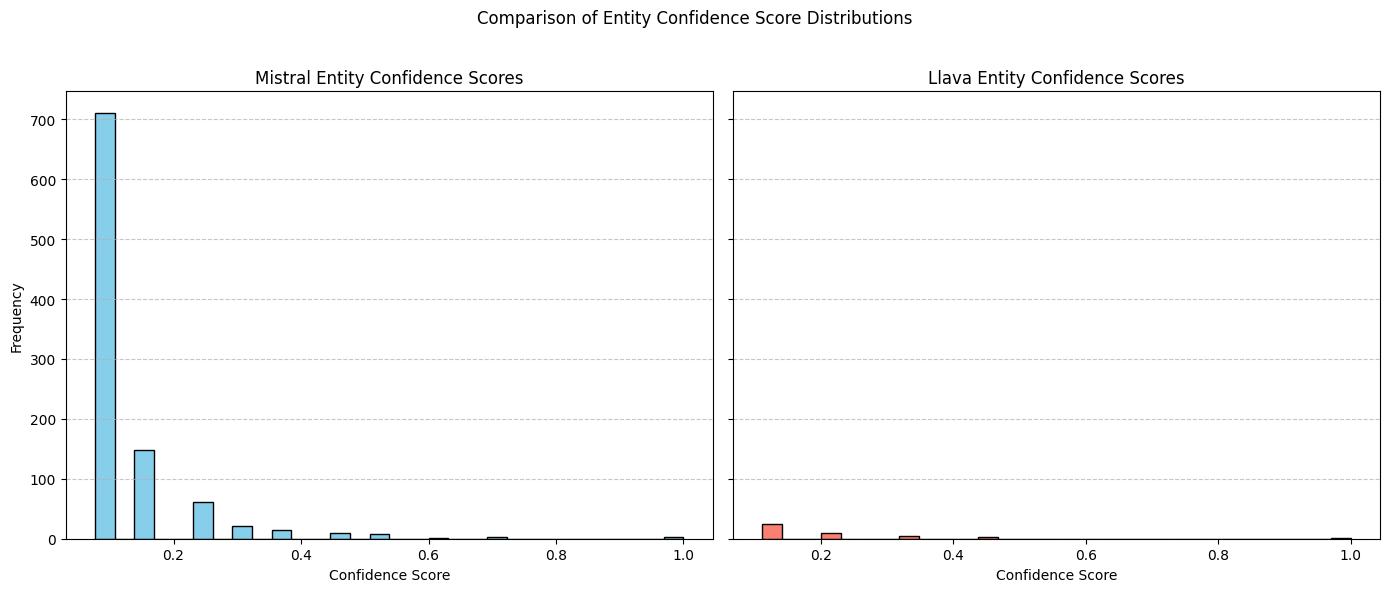

In [8]:
import matplotlib.pyplot as plt

mistral_confidences_df = pd.DataFrame(mistral_entity_confidences.items(), columns=['entity', 'confidence_score'])
llava_confidences_df = pd.DataFrame(llava_entity_confidences.items(), columns=['entity', 'confidence_score'])

# Plot side-by-side histograms
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Mistral confidence scores plot
axs[0].hist(mistral_confidences_df['confidence_score'], bins=30, color='skyblue', edgecolor='black')
axs[0].set_title('Mistral Entity Confidence Scores')
axs[0].set_xlabel('Confidence Score')
axs[0].set_ylabel('Frequency')
axs[0].grid(axis='y', linestyle='--', alpha=0.7)

# Llava confidence scores plot
axs[1].hist(llava_confidences_df['confidence_score'], bins=30, color='salmon', edgecolor='black')
axs[1].set_title('Llava Entity Confidence Scores')
axs[1].set_xlabel('Confidence Score')
axs[1].grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.suptitle('Comparison of Entity Confidence Score Distributions')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


- High Proportion of Low Confidence Scores:

The majority of entities have very low confidence scores (close to 0), suggesting that most nodes in the knowledge graph have low connectivity or centrality. This can indicate that many entities are isolated or only weakly connected to the graph’s main structure.
If low connectivity isn’t intentional, this could point to insufficient relationships or poorly integrated data.
- Few High Confidence Scores:

Only a small number of entities have confidence scores above 0.5, and very few reach a score close to 1. This suggests that only a few nodes are acting as central hubs in the graph. Ideally, these should represent key entities if the graph is accurately modeled.
If these central nodes don’t align with expected important entities, it may indicate structural issues or misplaced relationships.
- Possible Sparsity and Fragmentation:

The sharp decline in confidence scores from the peak near 0 indicates that the graph might be sparse, with many nodes only weakly connected to the overall structure.
This can be improved by adding more meaningful relationships or re-evaluating the existing connections to ensure they represent real-world relationships.

## LLM Evaluation

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from rouge import Rouge
import pandas as pd
import re
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from bert_score import score as bert_score

# Initialize the embedding model
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
rouge = Rouge()

# Function to retrieve relevant context from the knowledge graph
def retrieve_relevant_context(query, nodes_df, relationships_df):
    relevant_nodes = nodes_df[nodes_df['title'].str.contains(query, case=False, na=False)]
    context = "\n".join(relevant_nodes['title'].head(2))  # Get top 2 nodes
    return context

def clean_query(query):
    query = query.strip().lower()
    query = re.sub(r'[^\w\s]', '', query)  # Remove punctuation
    return query

def generate_answer(query, nodes_df, relationships_df):
    query = clean_query(query)
    relevant_nodes = []
    relevant_edges = []

    for _, node_data in nodes_df.iterrows():
        node_title = node_data['title'].strip().lower()
        if query == node_title:
            relevant_nodes.append(node_data['title'])
    
    for _, rel in relationships_df.iterrows():
        relationship_desc = rel['description'].strip().lower()
        source_node_title = rel['source'].strip().lower()
        target_node_title = rel['target'].strip().lower()
        
        if query == source_node_title or query == target_node_title:
            relevant_edges.append(f"{source_node_title} <-> {target_node_title}")
    
    answer = ""
    if relevant_nodes:
        answer += f"Relevant nodes: {', '.join(relevant_nodes)}\n"
    if relevant_edges:
        answer += f"Relevant relationships: {', '.join(relevant_edges)}"
    if not answer:
        answer = "No relevant information found based on the query."
    
    return answer

# Cosine similarity with TF-IDF
def cosine_sim(text1, text2):
    vectorizer = TfidfVectorizer().fit_transform([text1, text2])
    vectors = vectorizer.toarray()
    return cosine_similarity(vectors)[0, 1]

# Cosine similarity with embeddings
def cosine_similarity_score(ground_truth, generated_answer):
    gt_embedding = embedding_model.encode([ground_truth])
    gen_embedding = embedding_model.encode([generated_answer])
    return cosine_similarity(gt_embedding, gen_embedding)[0][0]

# Jaccard similarity
def jaccard_sim(text1, text2):
    set1 = set(text1.lower().split())
    set2 = set(text2.lower().split())
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    return len(intersection) / len(union)

# Calculate ROUGE scores
def calculate_rouge(reference, candidate):
    return rouge.get_scores(candidate, reference, avg=True)

# Calculate BERTScore
def calculate_bertscore(reference, candidate):
    P, R, F1 = bert_score([candidate], [reference], lang="en")
    return F1.item()  # Returning F1 score for simplicity

# Evaluate with multiple metrics
def evaluate_responses(queries, ground_truths, nodes_df, relationships_df):
    results = []
    for query, ground_truth in zip(queries, ground_truths):
        generated_answer = generate_answer(query, nodes_df, relationships_df)

        cosine_embedding = cosine_similarity_score(ground_truth, generated_answer)
        cosine_tfidf = cosine_sim(ground_truth, generated_answer)
        jaccard = jaccard_sim(ground_truth, generated_answer)
        rouge_scores = calculate_rouge(ground_truth, generated_answer)
        bert_f1 = calculate_bertscore(ground_truth, generated_answer)

        results.append({
            'query': query,
            'ground_truth': ground_truth,
            'generated_answer': generated_answer,
            'cosine_embedding': cosine_embedding,
            'cosine_tfidf': cosine_tfidf,
            'jaccard': jaccard,
            'rouge_1_f': rouge_scores['rouge-1']['f'],
            'rouge_2_f': rouge_scores['rouge-2']['f'],
            'rouge_l_f': rouge_scores['rouge-l']['f'],
            'bert_f1': bert_f1
        })
    
    return pd.DataFrame(results)

c:\Users\lameu\anaconda3\envs\graphrag\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [10]:
def visualize_knowledge_graph(nodes_df, relationships_df):
    G = nx.Graph()
    for _, node in nodes_df.iterrows():
        G.add_node(node['id'], label=node['title'], size=node['size'] * 10)
    for _, rel in relationships_df.iterrows():
        G.add_edge(rel['source'], rel['target'], label=rel['description'])

    plt.figure(figsize=(20, 20))
    pos = nx.spring_layout(G, k=0.1, iterations=50)

    nx.draw_networkx_nodes(G, pos, node_size=200, node_color="skyblue", alpha=0.7)
    nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.3)
    nx.draw_networkx_labels(G, pos, font_size=8, font_color="black", font_weight="bold")
    plt.title('Improved Graph Visualization - Mistral 30k')
    plt.show()
    
    return G

# Sample queries and ground truths
queries = ["HOZAN YAMAMOTO"]
ground_truths = ["""Hōzan Yamamoto (山本 邦山, Yamamoto Hōzan; October 6, 1937 - February 10, 2014 in Ōtsu,
Shiga prefecture) was a Japanese shakuhachi player, composer and lecturer. Yamamoto started playing
the Japanese bamboo flute shakuhachi at the age of nine. He was initially taught by his father and then
by Chozan Nakanishi. After graduating from Kyoto Junior College of Foreign Studies in 1958, he participated in UNESCO's
World Folk Music Festival and graduated from Seiha Music College in 1962. Together with koto player Shinichi Yuize and
Tony Scott, he recorded the album Music for Zen Meditation in February 1964."""]

# Assuming 'mistral_nodes' and 'mistral_relationships' are available in your code
# Evaluate with multiple metrics
evaluation_results = evaluate_responses(queries, ground_truths, mistral_nodes, mistral_relationships)

for _, result in evaluation_results.iterrows():
    print(f"Query: {result['query']}")
    print(f"Ground Truth: {result['ground_truth']}")
    print(f"Generated Answer: {result['generated_answer']}")
    print(f"Cosine Similarity (Embeddings): {result['cosine_embedding']}")
    print(f"Cosine Similarity (TF-IDF): {result['cosine_tfidf']}")
    print(f"Jaccard Similarity: {result['jaccard']}")
    print(f"BERTScore F1: {result['bert_f1']}")
    print("-" * 50)



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Query: HOZAN YAMAMOTO
Ground Truth: Hōzan Yamamoto (山本 邦山, Yamamoto Hōzan; October 6, 1937 - February 10, 2014 in Ōtsu,
Shiga prefecture) was a Japanese shakuhachi player, composer and lecturer. Yamamoto started playing
the Japanese bamboo flute shakuhachi at the age of nine. He was initially taught by his father and then
by Chozan Nakanishi. After graduating from Kyoto Junior College of Foreign Studies in 1958, he participated in UNESCO's
World Folk Music Festival and graduated from Seiha Music College in 1962. Together with koto player Shinichi Yuize and
Tony Scott, he recorded the album Music for Zen Meditation in February 1964.
Generated Answer: Relevant relationships: hozan yamamoto <-> japan, hozan yamamoto <-> shakuhachi, hozan yamamoto <-> seiha music college
Cosine Similarity (Embeddings): 0.6489465236663818
Cosine Similarity (TF-IDF): 0.15950756085750534
Jaccard Similarity: 0.05
BERTScore F1: 0.7999824285507202
--------------------------------------------------


- Cosine Similarity (Embeddings): 
Explanation: This metric uses sentence embeddings (from Sentence Transformers) to compare the semantic similarity between the generated answer and the ground truth.
Interpretation: A score of 0.64 indicates moderate similarity. It's not perfect, but it suggests that the generated answer captures some of the semantic content from the ground truth. Generally, scores closer to 1 indicate high similarity, so there is room for improvement here.

- Cosine Similarity (TF-IDF):
Explanation: This score is based on TF-IDF (term frequency-inverse document frequency), which focuses on word-level similarities rather than semantic meaning.
Interpretation: A score of 0.1 indicates that while there are some overlaps in words between the generated answer and the ground truth, they are not particularly strong. This makes sense since the TF-IDF approach doesn’t capture the nuances of meaning as well as embeddings do. Lower TF-IDF scores like this are typical in cases where the generated response captures the context semantically but doesn’t match word-for-word.

- Jaccard Similarity: 
Explanation: Jaccard Similarity measures the overlap of unique words between the generated answer and the ground truth.
Interpretation: A score of 0.05 is relatively low, indicating minimal overlap in the actual words used between the generated answer and ground truth. This low score is expected because Jaccard is quite sensitive to the exact words used, so it doesn’t perform well on semantically similar but differently worded texts.

- BERTScore F1: 
Explanation: BERTScore uses BERT embeddings to measure the semantic similarity between the generated answer and the ground truth, evaluating on a word level but taking context into account.
Interpretation: A BERTScore F1 of 0.80 is relatively high and indicates a good degree of semantic alignment between the generated answer and the ground truth. This suggests that the generated answer captures much of the underlying meaning, even if the wording is different.